Here is the background information on your task

Great work! The desk now has the price data they need. The final ingredient before they can begin trading with the client is the pricing model. Alex tells you the client wants to start trading as soon as possible. They believe the winter will be colder than expected, so they want to buy gas now to store and sell in winter in order to take advantage of the resulting increase in gas prices. They ask you to write a script that they can use to price the contract. Once the desk are happy, you will work with engineering, risk, and model validation to incorporate this model into production code.

The concept is simple: any trade agreement is as valuable as the price you can sell minus the price at which you are able to buy. Any cost incurred as part of executing this agreement is also deducted from the overall value. So, for example, if I can purchase a million MMBtu of natural gas in summer at $2/MMBtu, store this for four months, and ensure that I can sell the same quantity at $3/MMBtu without incurring any additional costs, the value of this contract would be ($3-$2) *1e6 = $1million. If there are costs involved, such as having to pay the storage facility owner a fixed fee of $100K a month, then the 'value' of the contract, from my perspective, would drop by the overall rental amount to $600K. Another cost could be the injection/withdrawal cost, like having to pay the storage facility owner $10K per 1 million MMBtu for injection/withdrawal, then the price will further go down by $10K to $590K. Additionally, if I am supposed to foot a bill of $50K each time for transporting the gas to and from the facility, the cost of this contract would fall by another $100K. Think of the valuation as a fair estimate at which both the trading desk and the client would be happy to enter into the contract. 

You need to create a prototype pricing model that can go through further validation and testing before being put into production. Eventually, this model may be the basis for fully automated quoting to clients, but for now, the desk will use it with manual oversight to explore options with the client. 

You should write a function that is able to use the data you created previously to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before. Consider all the cash flows involved in the product.

The input parameters that should be taken into account for pricing are:

Injection dates. 
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.

Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. Test your code by selecting a few sample inputs.

inj_date = injection date, usually date at which natural gas is bought
withd_date = withdrawal date, usually date at which natural gas is sold

delta_t = time in storage [months] = withd_date - inj_date
V = volume [MMBtu] bought 
B = buy price per unit [$/MMBtu]
S = sell price per unit [$/MMBtu]
IR = injection rate [$/MMBtu]
V_max = maximum volume that can be stored [MMBtu]
St_Cost_fixed = fixed cost [$/month] * delta_t [month] 
St_cost_variable = V [MMBtu] * ( storage rate [$/month] / V_max [MMBtu]) * delta_t [months]  = f(V, delta_t)

TR_fixed = fixed cost to and from facility transport [$]
TR_variable = ( transport cost for max volume [$] / V_max [MMBtu] ) * V [MMBtu] = f(V)

Price of Contract = (S - B - IR)*V - St_Cost - TR_cost


e.g.

delta_t = 4 months
V = 1 x 10^6 MMBtu
B = 2 $/MMBtu
S = 3 $/MMBtu
IR = 10k$ / 1 x 10^6 MMBtu
St_Cost_fixed = ( 100k$/month ) * delta_t
St_Cost_variable = ( 100k$/month / V_max ) * V * delta_t

TR_fixed = 2 transports * 50$ = 100k$
TR_variable = (2 * 50k$ / V_max) * V


Price of Contract = (3 - 2 - 10k/10^6) * 10^6 - (100k * 4) - (2 * 50k) 



In [1]:
import pandas as pd

In [2]:
# Read the CSV file
df = pd.read_csv("Nat_Gas.csv")

In [3]:
df.head()
#Prices column is the historical Purchase Price per MMBtu

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [4]:
df.tail()

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


<Axes: >

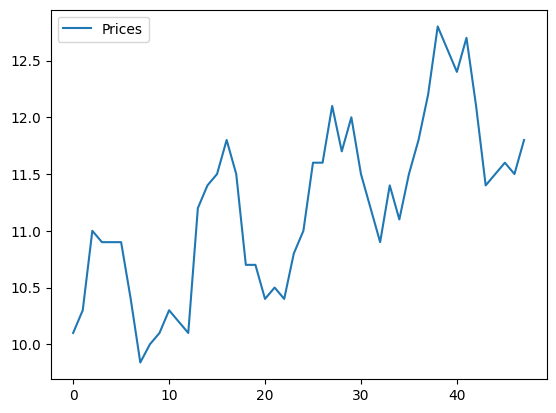

In [6]:
df.plot()

In [20]:
import pandas as pd
import numpy as np
import datetime 


# manual inputs
inj_date_ser = pd.Series(['5/31/24', '11/30/20','6/30/24'])
withd_date_ser = pd.Series(['9/30/24', '1/31/21','10/31/24'])
B_ser = pd.Series([11.4, 10.3, 2])
S_ser = pd.Series([11.8, 10.9, 3])
V_ser = pd.Series([1e6, 3e6, 1e6]) # MMBtu


input_data = {'inj_date':pd.to_datetime(inj_date_ser), 'withd_date':pd.to_datetime(withd_date_ser), 'B':B_ser, 'S':S_ser, 'V':V_ser}
input_df = pd.DataFrame(data=input_data)



# takes in input_df dataframe (since, in most cases, data will be coming from csv files) and cost rates as inputs
# columns of input_df: (inj_date, withd_date, B, S, V, Vmax=1e6)
# for any pair of inject & withdraw dates, assume their own set volume


def NG_contract_price(input_df, Vmax=1e6, IR=10000/1e6, St_Cost=100000, TR_Cost=50000):

    delta_t_ser = (pd.to_datetime(input_df['withd_date']) - pd.to_datetime(input_df['inj_date'])).apply(lambda x : x.days // 30.44) # 30.44 is the approximate 

    st_cost_var = (St_Cost / Vmax) * input_df['V'] * delta_t_ser

    tr_cost_var = (2 * TR_Cost / Vmax) * input_df['V']

    price_of_contract = (input_df['S'] - input_df['B'] - IR)*input_df['V'] - st_cost_var - tr_cost_var

    

    return price_of_contract # returns a df with columns inj_date, withd_date, B, S, V, price of contract



C:\Users\jpkdu\AppData\Local\Temp\ipykernel_5556\4071609887.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_data = {'inj_date':pd.to_datetime(inj_date_ser), 'withd_date':pd.to_datetime(withd_date_ser), 'B':B_ser, 'S':S_ser, 'V':V_ser}
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_5556\4071609887.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  input_data = {'inj_date':pd.to_datetime(inj_date_ser), 'withd_date':pd.to_datetime(withd_date_ser), 'B':B_ser, 'S':S_ser, 'V':V_ser}


In [24]:
input_df # for small data test

,inj_date,withd_date,B,S,V
0,2024-05-31,2024-09-30,11.4,11.8,1000000.0
1,2020-11-30,2021-01-31,10.3,10.9,3000000.0
2,2024-06-30,2024-10-31,2.0,3.0,1000000.0


In [23]:
NG_contract_price(input_df=input_df) # cost rates used as default inputs

0   -110000.0
1    870000.0
2    490000.0
dtype: float64

In [29]:
NG_contract_price(input_df=input_df).sum()

1249999.999999999